# Deep Learning Library

In this notebook, we demonstrate the use of the MicroAI `nn` library, built on top of the `autograd` implementation. The library is built to mimic the PyTorch interface and implements key building blocks necessary in modern deep learning architectures. We build two neural networks and train them to solve a simple binary classification problem. This project was inspired by the [
Andrej Karpathy's Micrograd implementation](https://github.com/karpathy/micrograd).

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import tqdm

In [2]:
from microai.nn.activations import ReLU, Sigmoid, Tanh
from microai.nn.layers import Linear, Sequential
from microai.nn.losses import BCELoss, MSELoss
from microai.nn.modules import Module
from microai.nn.optimizers import SGD
from microai.nn.schedulers import ExponentialLR

In [3]:
seed = 5669
torch.manual_seed(seed)
random.seed(seed)

## Toy Example

To showcase some basic functionality, we commence with a simple example and a tiny neural network to demonstrate a training pipeline.

In [4]:
inputs = [[1., 2.], [-1., 3.], [-5., 2.], [-4, 0]]
target = [-1, 1, 1, 1]

In [5]:
model = Sequential(
    Linear(2, 4),
    Tanh(),
    Linear(4, 4),
    Tanh(),
    Linear(4, 1),
)
loss_fn = MSELoss()
optimizer = SGD(model.parameters(), lr=3e-2)

In [6]:
for epoch in range(101):
    pred = map(model, inputs)
    loss = loss_fn(target, pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 25 == 0: print(f"Epoch: {epoch}, Loss: {loss.data}")

Epoch: 0, Loss: 9.359789257133093
Epoch: 25, Loss: 0.27572097520566796
Epoch: 50, Loss: 0.012161843271825356
Epoch: 75, Loss: 0.004946552632893482
Epoch: 100, Loss: 0.0032366293683858236


## Non-Linear Classification

Next, we test the capabilities of the framework on a more complex classification problem. We solve this using our framework, and also using PyTorch, which serves as our baseline.

### Utilities

In this section we define some utility functions that we will use throughout this notebook.

In [7]:
def draw_decision_boundary(X, Y, model):
    step = 0.25
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    mesh = np.c_[xx.ravel(), yy.ravel()]

    if isinstance(model, Module):
        # evaluates microai model
        scores = map(model, mesh)
        Z = [1 if score.data > 0.5 else 0 for score in scores]
        Z = np.array(Z).reshape(xx.shape)
    else:
        # evaluates pytorch model
        scores = model(torch.tensor(mesh, dtype=torch.float32))
        Z = (scores > 0.5).float().numpy()
        Z = Z.reshape(xx.shape)

    _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, cmap="autumn", alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

### Dataset

We start by creating some non-linearly separable data using `SKLearn`.

In [8]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [9]:
X, Y = make_moons(n_samples=300, noise=0.1, random_state=seed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

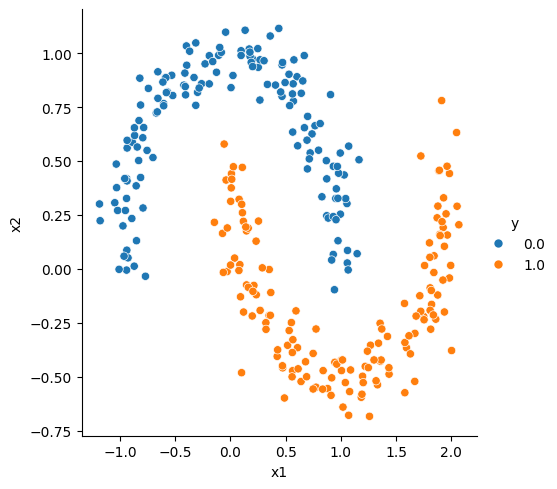

In [10]:
df = pd.DataFrame(np.concatenate((X, Y[:, None]), axis=1), columns=["x1", "x2", "y"])
_ = sns.relplot(df, x="x1", y="x2", hue="y")

### PyTorch Implementation

To get a baseline, we first solve the problem using PyTorch.

In [11]:
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [12]:
x_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train[:, None], dtype=torch.float32)
x_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test[:, None], dtype=torch.float32)

In [13]:
batch_size = 32
train_dataloader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [14]:
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid(),
)

In [15]:
loss_fn = nn.BCELoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=5e-1, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
epochs = 100

In [16]:
def train_epoch(dataloader):
    epoch_loss, epoch_acc = [], []

    for x, y in dataloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.detach().item())
        epoch_acc.append((y == (y_pred > 0.5).int()).float().mean())
    
    return np.mean(epoch_loss), np.mean(epoch_acc)

In [17]:
def eval_epoch(dataloader):
    epoch_loss, epoch_acc = [], []

    for x, y in dataloader:
        with torch.no_grad():
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

        epoch_loss.append(loss.item())
        epoch_acc.append((y == (y_pred > 0.5).int()).float().mean())
    
    return np.mean(epoch_loss), np.mean(epoch_acc)

In [18]:
for epoch in (pbar := tqdm.tqdm(range(1, epochs + 1), desc="Training")):
    train_loss, train_acc = train_epoch(train_dataloader)
    scheduler.step()
    test_loss, test_acc = eval_epoch(test_dataloader)
    pbar.set_postfix_str(f"loss={np.mean(train_loss):.2f}; acc={np.mean(train_acc):.2f}; test_loss={np.mean(test_loss):.2f}; test_acc={np.mean(test_acc):.2f}")

Training:   6%|▌         | 6/100 [00:00<00:03, 29.68it/s, loss=0.27; acc=0.87; test_loss=0.26; test_acc=0.87]

Training: 100%|██████████| 100/100 [00:02<00:00, 45.07it/s, loss=0.01; acc=1.00; test_loss=0.02; test_acc=0.99]


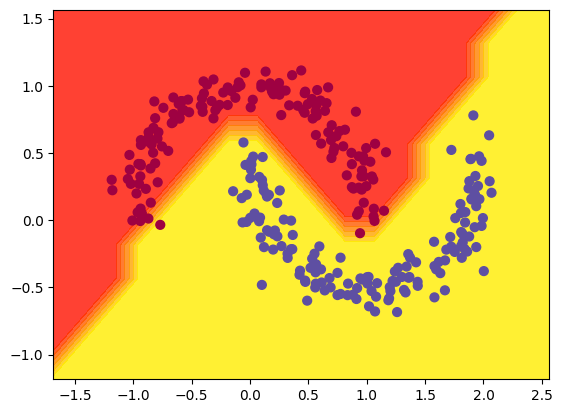

In [19]:
draw_decision_boundary(X=X, Y=Y, model=model.eval())

### MicroAI Implementation

In this section, we design an equivalent network using components in the `microai` framework.

In [20]:
model = Sequential(
    Linear(2, 16),
    ReLU(),
    Linear(16, 16),
    ReLU(),
    Linear(16, 1),
    Sigmoid(),
)

In [21]:
loss_fn = BCELoss(reduction="mean")
optimizer = SGD(model.parameters(), lr=5e-1)
scheduler = ExponentialLR(optimizer, gamma=0.99)
num_epochs = 100
batch_size = 32
x_train, y_train = X_train.copy(), Y_train.copy()
x_test, y_test = X_test.copy(), Y_test.copy()

In [22]:
def calc_loss(y_true, y_pred, weight_decay: float = 1e-3):
    loss_pred = loss_fn(y_true, y_pred)
    loss_reg = sum([p*p for p in model.parameters()])
    loss = loss_pred + weight_decay * loss_reg
    loss = loss_pred
    return loss

In [23]:
def train_epoch(X, Y):
    indices = np.random.permutation(len(X))
    X, Y = X[indices].tolist(), Y[indices].tolist()
    epoch_loss, epoch_acc = [], []

    for i in range(0, math.ceil(len(X) / batch_size)) :
        index = i * batch_size
        x, y = X[index: index + batch_size], Y[index:index + batch_size]

        y_pred = list(map(model, x))
        loss = loss_fn(y, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss)
        epoch_acc.append(np.mean([(yt == int(yp.data > 0.5)) for yt, yp in zip(y, y_pred)]))
    
    return np.mean([i.data for i in epoch_loss]), np.mean(epoch_acc)

In [24]:
def eval_epoch(X, Y):
    x, y = X.tolist(), Y.tolist()

    y_pred = list(map(model, x))
    loss = loss_fn(y, y_pred)

    epoch_loss = loss
    epoch_acc = np.mean([(yt == int(yp.data > 0.5)) for yt, yp in zip(y, y_pred)])
    return epoch_loss.data, epoch_acc

In [25]:
for epoch in (pbar := tqdm.tqdm(range(1, num_epochs + 1), desc="Training")):
    train_loss, train_acc = train_epoch(x_train, y_train)
    scheduler.step()
    test_loss, test_acc = eval_epoch(x_test, y_test)
    pbar.set_postfix_str(f"loss={train_loss:.2f}; acc={train_acc:.2f}; test_loss={test_loss:.2f}; test_acc={test_acc:.2f}")

Training: 100%|██████████| 100/100 [06:06<00:00,  3.66s/it, loss=0.00; acc=1.00; test_loss=0.01; test_acc=1.00]


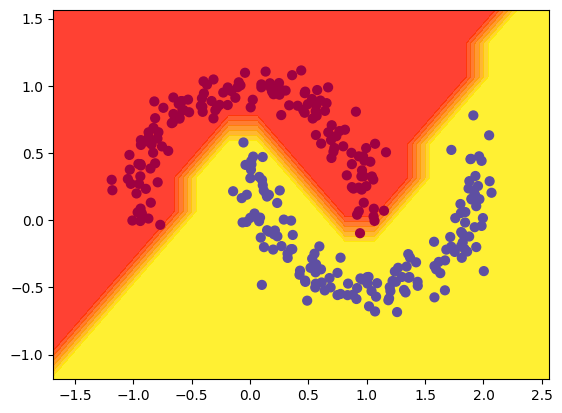

In [26]:
draw_decision_boundary(X=X, Y=Y, model=model)